Attack Count Prediction (Regression with XgBoost)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df=pd.read_excel('2020-2025-education-in-danger-incident-data.xlsx')
df

,Date,Event Description,Country,Country ISO,Admin 1,Latitude,Longitude,Geo Precision,Location of event,Reported Perpetrator,...,Educators Arrested,Known Educators Kidnap Or Arrest Outcome,Students Attacked in School,Students Killed,Students Injured,Students Kidnapped,Known Student Kidnap Or Arrest Outcome,Students Arrested,Sexual Violence Affecting School Age Children,SiND Event ID
0,2025-05-25,NaN,Ukraine,UKR,Chernihiv Oblast,51.4,31.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100323
1,2025-05-24,NaN,Ukraine,UKR,Obolonskyi district,50.5,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100318
2,2025-05-24,NaN,Ukraine,UKR,Dniprovskyi district,50.4,30.5,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,100317
3,2025-05-22,NaN,Ukraine,UKR,Donetsk Oblast,48.5,37.6,(2) 25 km Precision,Education Building,Other,...,0,NaN,0,0,0,0,NaN,0,0,100315
4,2025-05-12,NaN,Ukraine,UKR,Sumy Oblast,50.9,34.2,(2) 25 km Precision,Education Building,Foreign Forces - Military,...,0,NaN,0,0,0,0,NaN,0,0,99014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4602,2020-01-05,NaN,Syria,SYR,Idlib Governorate,35.8,36.6,"(4) Province, State, Governorate",Education Building,Other,...,0,NaN,0,0,0,0,NaN,0,0,24953
4603,2020-01-05,NaN,Burundi,BDI,Bujumbura Rural Province,-3.4,29.4,"(4) Province, State, Governorate",Education Building,NSA,...,0,NaN,0,0,1,0,NoInformation,1,0,25193
4604,2020-01-03,NaN,Libya,LBY,Tripoli,32.8,13.1,(2) 25 km Precision,Education Building,NSA,...,0,NaN,2,0,1,0,NaN,0,0,24925
4605,2020-01-01,NaN,Mali,MLI,Mopti,14.1,-2.0,(2) 25 km Precision,Unspecified Location,NSA,...,0,NaN,0,0,0,0,NaN,0,0,24799


In [3]:
df.isnull().sum()

Date                                                0
Event Description                                4607
Country                                             0
Country ISO                                         0
Admin 1                                             4
Latitude                                          626
Longitude                                         626
Geo Precision                                       1
Location of event                                   4
Reported Perpetrator                                0
Reported Perpetrator Name                           0
Weapon Carried/Used                                 0
Type of education facility                          0
Attacks on Schools                                  0
Attacks on Universities                             0
Military Occupation of Education facility           0
Arson attack on education facility                  0
Forced Entry into education facility                0
Damage/Destruction To Ed fac

Handling Missing Values

In [4]:
# 2. Numerical columns ke liye missing values fill (mean/median)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 3. Categorical columns ke liye missing values fill (mode)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 4. Agar kuch irrelevant columns ho jisme bahut zyada missing hai (>50%), to unhe drop karo
threshold = 0.5  # 50%
df = df.dropna(thresh=len(df) * threshold, axis=1)

print("Missing values handled successfully!")


Missing values handled successfully!


In [5]:
#to check if any missing values remain
print("Remaining missing values per column:\n", df.isnull().sum())

Remaining missing values per column:
 Date                                             0
Country                                          0
Country ISO                                      0
Admin 1                                          0
Latitude                                         0
Longitude                                        0
Geo Precision                                    0
Location of event                                0
Reported Perpetrator                             0
Reported Perpetrator Name                        0
Weapon Carried/Used                              0
Type of education facility                       0
Attacks on Schools                               0
Attacks on Universities                          0
Military Occupation of Education facility        0
Arson attack on education facility               0
Forced Entry into education facility             0
Damage/Destruction To Ed facility Event          0
Attacks on Students and Teachers            

In [6]:
#Create Target Column (Total_Attacks)
df["Total_Attacks"] = (
    df["Attacks on Schools"] +
    df["Attacks on Universities"] +
    df["Military Occupation of Education facility"] +
    df["Arson attack on education facility"] +
    df["Attacks on Students and Teachers"]
)

In [7]:
#Encode Categorical Columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [8]:
#Define Features (X) and Target (y)
y = df["Total_Attacks"]
X = df.drop(columns=["Total_Attacks"])

In [9]:
# Handle datetime columns
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    # Extract useful datetime features
    X[f'{col}_year'] = X[col].dt.year
    X[f'{col}_month'] = X[col].dt.month
    X[f'{col}_day'] = X[col].dt.day
    # Drop original datetime column
    X = X.drop(columns=[col])

# Convert remaining features to appropriate types
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')
    elif X[col].dtype not in ['int64', 'float64']:
        X[col] = X[col].astype('float64')

In [10]:
# Train XGBoost Regressor with categorical feature support
xgb_reg = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    enable_categorical=True  # Enable categorical feature support
)

# Retrain with processed features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_reg.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [11]:
#Predictions
y_pred = xgb_reg.predict(X_test)

In [12]:
#Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Regression Model Performance:")
print("RMSE:", rmse)
print("R² Score:", r2)

# R² Score ~ 1 ke jitna close ho, utna acha model hai.

# MAE / RMSE jitna chhota ho, utna better model hai.

Regression Model Performance:
RMSE: 0.006824740484806882
R² Score: 0.9999266862869263


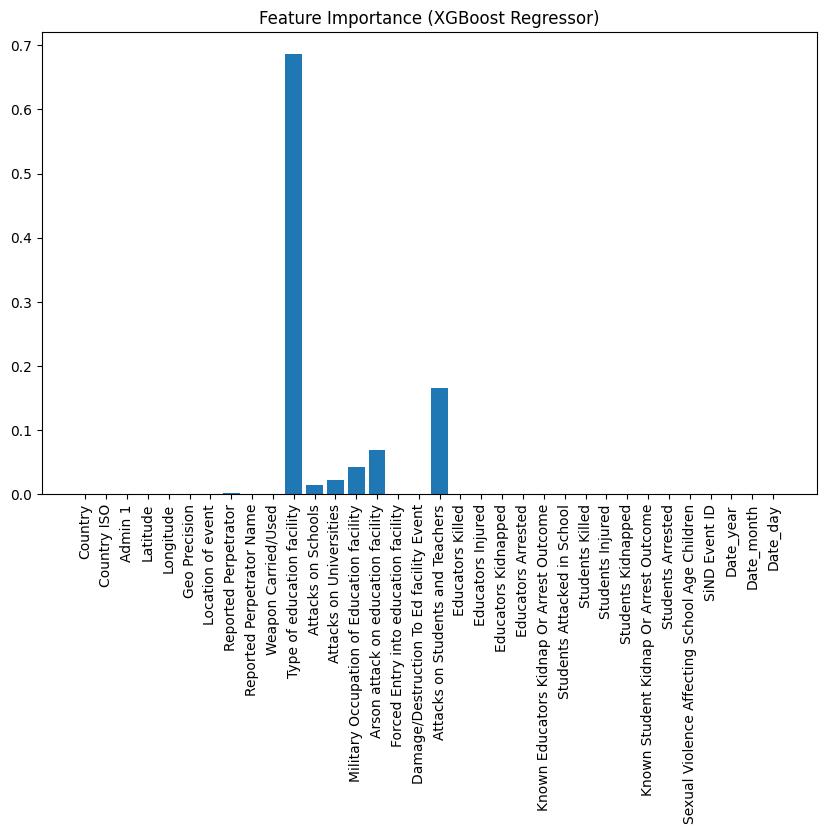

In [13]:
#Feature Importance
plt.figure(figsize=(10,6))
plt.bar(X.columns, xgb_reg.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importance (XGBoost Regressor)")
plt.show()

In [14]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained model (not the notebook) with .joblib extension
from joblib import dump, load
model_path = os.path.join('models', 'regression_model.joblib')

# Save the trained model instance
with open(model_path, 'wb') as f:
    dump(xgb_reg, f)  # Use xgb_reg instead of model
    print(f"Model saved successfully to {model_path}")

Model saved successfully to models\regression_model.joblib
